In [ ]:
dbutils.library.restartPython()

# Transformer model training

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, Dropout, Dense, MultiHeadAttention, Input, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import random
import datetime

# Get the current date
current_date = datetime.datetime.now().date()

# Convert the date to a string
date_string = current_date.strftime('%Y-%m-%d')  # Formats the date as "Year-Month-Day"


# Full list of symbols in Russell 2000 - placeholder for actual list
all_symbols = ['SMCI', 'MSTR', 'CVNA', 'DOC', 'PR', 'PSN', 'INSM', 'FIX', 'FTAI', 'COKE',
               'APG', 'ELF', 'AMKR', 'APPF', 'ONTO', 'PCVX', 'LNW', 'WFRD', 'ITCI', 'SFM',
               'FLR', 'CERE', 'AIT', 'ATI', 'ENSG', 'FN', 'LNTH', 'ANF', 'UFPI', 'MTDR',
               'SSD', 'MLI', 'HLNE', 'SPSC', 'VKTX', 'RVMD', 'DRS', 'SSB', 'DUOL',
               'ALTR', 'BPMC', 'CHRD', 'SMMT', 'HALO', 'NSIT', 'MTSI', 'IBP', 'TMHC', 'AAON', 'CRS', 
               'EVLO','PRST', 'VAXX', 'TWOU', 'LPTV', 'AKTS', 'MAXN',
                'DZSI', 'CMAX', 'CARA', 'XAIR', 'VLD', 'WKHS', 'CUTR', 'BIG',
                'BTAI', 'FTCI', 'CUE', 'GORV', 'IMRX', 'EVA', 'BGFV', 'SPWR',
                'RBOT', 'ATRA', 'CARM', 'DFLI', 'BHIL', 'RENT', 'KZR', 'FGEN',
                'VATE', 'BGXX', 'VTNR', 'RPHM', 'PRTS', 'EYEN', 'XGN', 'AVTE',
                'RLYB', 'CMBM', 'VOXX', 'DNMR', 'EGRX', 'TSBX', 'MURA', 'OM',
                'GRTS', 'VOR','BRBS','FOSL'
]

start_date = '2021-07-01'
end_date = '2024-07-01'
# Download data
try:
    data = yf.download(all_symbols, start=start_date, end=end_date)['Adj Close'].dropna(axis=1, how='all')
except Exception as e:
    print(f"Failed to download data: {e}")
    raise SystemExit("Exiting due to data download error.")

weekly_data = data.resample('W').last()
weekly_returns = weekly_data.pct_change().dropna()

scaler = StandardScaler()
mean_returns = np.mean(np.array(weekly_returns), axis=0)
mean_returns = scaler.fit_transform(mean_returns.reshape(-1,1))
scores = mean_returns / scaler.fit_transform(np.std(np.array(weekly_returns), axis=0).reshape(-1,1))
top_indices = np.argsort(scores.flatten())[-len(all_symbols):] # Select top stocks
top_stocks = [all_symbols[i] for i in top_indices]

# Filter data to include only top stocks
data = data[top_stocks]
#weekly_data = data.resample('W').last()
#weekly_returns = weekly_data.pct_change().dropna()
weekly_data = data.resample('W').last()
weekly_returns = weekly_data.pct_change().dropna()

# Scale features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(weekly_returns)
forecast_horizon = 8

# Prepare sequences for training
def create_sequences(data, seq_length=10, forecast_horizon=4):
    X, Y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i + seq_length])
        Y.append(data[i + seq_length:i + seq_length + forecast_horizon])
    return np.array(X), np.array(Y)

X, Y = create_sequences(scaled_features, 12, forecast_horizon = forecast_horizon)

# Define the Transformer model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape, num_features):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(4):  # Number of Transformer blocks
        x = TransformerBlock(embed_dim=input_shape[-1], num_heads=4, ff_dim=256, rate=0.5)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(forecast_horizon * num_features, activation='linear')(x)
    outputs = Reshape((forecast_horizon, num_features))(outputs)  # Ensure output is reshaped to [forecast_horizon, num_features]
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=3e-5), loss="mse")
    return model

num_features = data.shape[1]  # Adjust this if your data preprocessing changes the number of features
model = build_transformer_model((X.shape[1], X.shape[2]), num_features)
model.summary()  # Always good to check the model structure

model.fit(X, Y, epochs=200, batch_size=10, verbose=1, validation_split=0.2,
          callbacks=[ModelCheckpoint("best_model.keras", save_best_only=True),
                     EarlyStopping(patience=5, restore_best_weights=True,min_delta=1e-4,monitor='val_loss')])

# Forecast future weekly returns
forecasted_returns = model.predict(X[-1].reshape(1, *X[-1].shape)).reshape(-1, len(data.columns))
forecasted_returns = scaler.inverse_transform(forecasted_returns)

[*********************100%***********************]  101 of 101 completed


Model: "functional_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_120 (InputLayer)    │ (None, 12, 101)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_96            │ (None, 12, 101)        │       217,002 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_97            │ (None, 12, 101)        │       217,002 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_98            │ (None, 12, 101)        │       217,002 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_99            │ (None, 12, 101)        │       217,002 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_24     │ (None, 101)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 128)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_324 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 808)            │       104,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_24 (Reshape)            │ (None, 8, 101)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 985,296 (3.76 MB)

 Trainable params: 985,296 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.2963 - val_loss: 0.3003
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step - loss: 0.3008 - val_loss: 0.3003
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step - loss: 0.2960 - val_loss: 0.3003
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step - loss: 0.2961 - val_loss: 0.3002
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step - loss: 0.3038 - val_loss: 0.3002
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step - loss: 0.3058 - val_loss: 0.3002
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


# Portfolio Optimisation

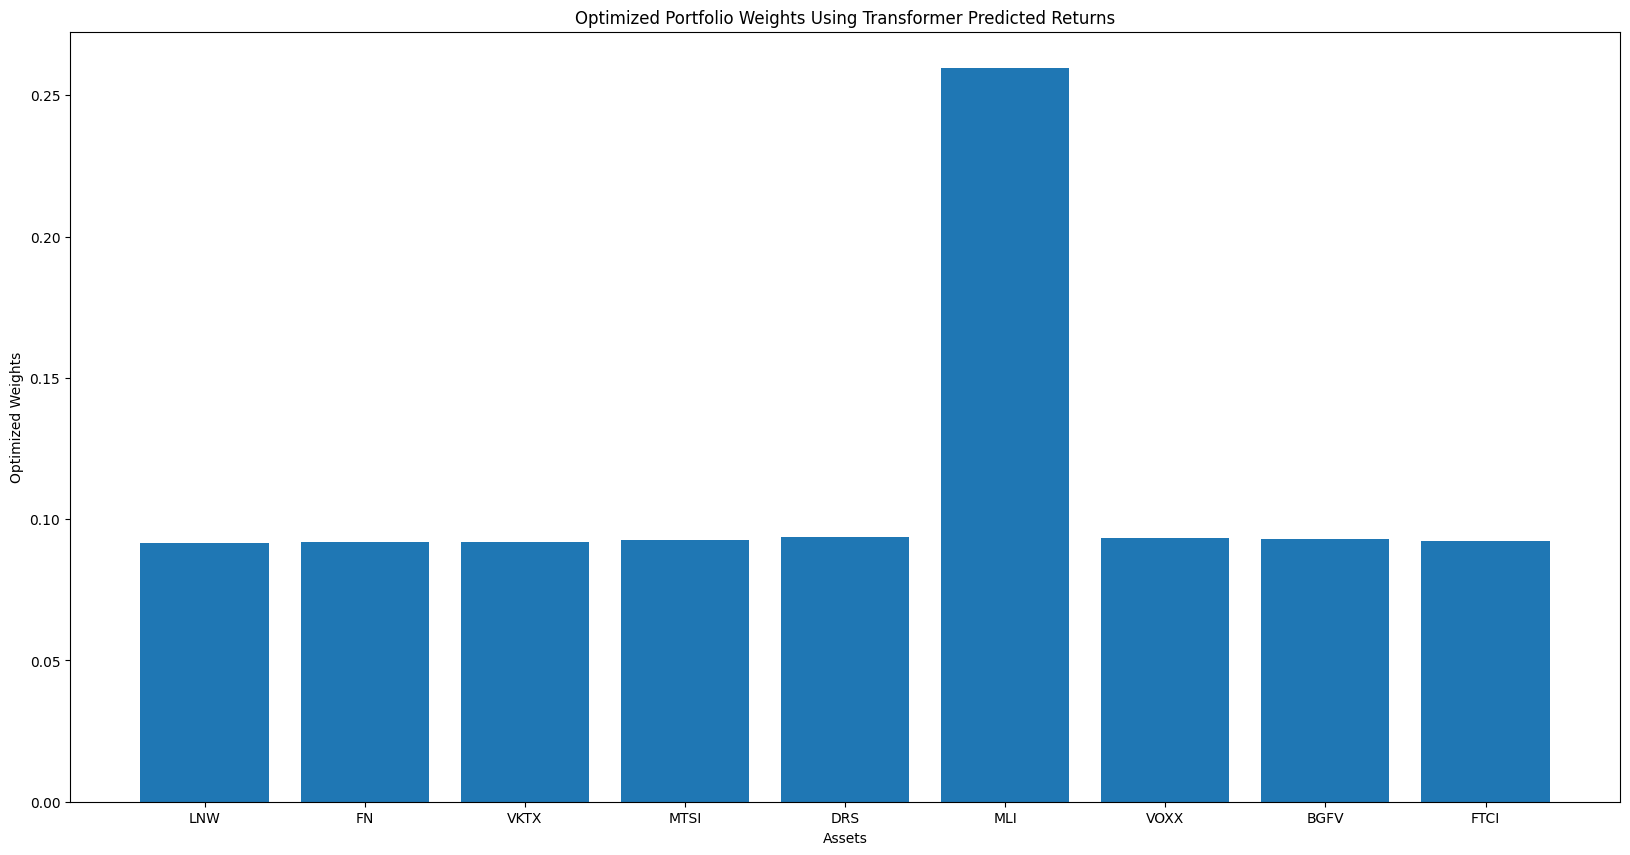

In [ ]:
def markowitz_optimization(returns, cov_matrix, risk_aversion=4):
    n_assets = returns.shape[0]
    def objective(weights):
        return -(np.dot(weights, returns) - risk_aversion * np.dot(weights.T, np.dot(cov_matrix, weights)))
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    bounds = [(0, 1) for _ in range(n_assets)]
    result = minimize(objective, np.full(n_assets, 1/n_assets), method='SLSQP', bounds=bounds, constraints=constraints)
    if not result.success:
        print("Optimization failed: ", result.message)
        return None
    return result.x

risk_av = 3
# Combine historic and forecasted returns
all_returns = np.concatenate((weekly_returns.values, forecasted_returns), axis=0)
scaler = StandardScaler()
mean_returns = np.mean(all_returns, axis=0)
mean_returns = scaler.fit_transform(mean_returns.reshape(-1,1))
volatility = scaler.fit_transform(np.std(all_returns, axis=0).reshape(-1,1))
factor = 0.2

def allocate_portfolio(risk_aversion, high_cap_weight_base, low_cap_weight_base):
    high_cap_weight = high_cap_weight_base + factor * (risk_aversion - 1.5) * (1 - high_cap_weight_base)
    low_cap_weight = low_cap_weight_base - factor * (risk_aversion - 1.5) * low_cap_weight_base
    return high_cap_weight, low_cap_weight

# Base weights assuming a balanced risk aversion (lambda = 1)
high_cap_weight_base = 0.55  # 55% to high cap at neutral risk aversion
low_cap_weight_base = 0.45  # 45% to low cap at neutral risk aversion

high_cap_weight, low_cap_weight = allocate_portfolio(risk_av, high_cap_weight_base, low_cap_weight_base)


top_indices_high = np.argsort(mean_returns[:50].flatten())[-int(high_cap_weight*10):] # Select top stocks
top_indices_low = np.argsort(-mean_returns[50:].flatten())[:int(low_cap_weight*10)] + 50
top_indices = []
top_indices.extend(top_indices_high)
top_indices.extend(top_indices_low)
top_stocks = [all_symbols[i] for i in top_indices]
top_mean_returns = mean_returns[top_indices]
cov_matrix = np.cov(top_mean_returns, rowvar=False)

optimized_weights = markowitz_optimization(top_mean_returns, cov_matrix,risk_av)

# Visualize the optimized portfolio weights
plt.figure(figsize=(20, 10))
plt.bar(top_stocks, optimized_weights)
plt.xlabel('Assets')
plt.ylabel('Optimized Weights')
plt.title('Optimized Portfolio Weights Using Transformer Predicted Returns')
plt.show()

In [ ]:
df = pd.DataFrame({
    'Stock': top_stocks,
    'Optimized Weight': optimized_weights
})
df.columns = ['Stock', 'Optimized_Weight']

# Convert the DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(df)

# Create the database if it doesn't exist
spark.sql("CREATE DATABASE IF NOT EXISTS adhi_db")

# Write the DataFrame to the Spark SQL table, trying to overwrite the existing data
if isinstance(risk_av, float):
    formatted_risk_av = str(risk_av).replace('.', '_')
else:
    formatted_risk_av = str(risk_av)

spark_df.write.option("overwriteSchema", "true").mode("overwrite").saveAsTable(f"adhi_db.trans_weights_{formatted_risk_av}")

In [ ]:
# Symbols for your stocks and weights from Markowitz Optimization
weights = optimized_weights

# Fetch historical data
data = yf.download(top_stocks, start=start_date, end=end_date)['Adj Close']

# Function to calculate returns for holding periods
def calculate_returns_for_periods(data, periods):
    if isinstance(data, pd.Series):
        # Handle Series input for single stock/index data
        returns = pd.DataFrame(index=data.index)
        for period in periods:
            returns[f'{period} day return'] = (data.pct_change(periods=period)* weights).sum(axis=1)
    elif isinstance(data, pd.DataFrame):
        # Handle DataFrame input for multiple stocks
        returns = pd.DataFrame(index=data.index)
        for period in periods:
            returns[f'{period} day return'] = (data.pct_change(periods=period)* weights).sum(axis=1)
    return returns

# Calculate returns for various holding periods
holding_periods = list(range(5,405,5))  # Example holding periods
portfolio_returns = calculate_returns_for_periods(data, holding_periods)
risks = portfolio_returns.std()


[*********************100%***********************]  9 of 9 completed


In [ ]:
# Fetch market index data
market_data = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']  # Russell 2000 as the market index

def calculate_returns_for_periods_market(data, periods):
    if isinstance(data, pd.Series):
        # Handle Series input for single stock/index data
        returns = pd.DataFrame(index=data.index)
        for period in periods:
            returns[f'{period} day return'] = data.pct_change(periods=period)
    elif isinstance(data, pd.DataFrame):
        # Handle DataFrame input for multiple stocks
        returns = pd.DataFrame(index=data.index)
        for period in periods:
            returns[f'{period} day return'] = data.pct_change(periods=period)
    return returns

# Calculate market returns for the same holding periods
market_returns = calculate_returns_for_periods_market(market_data, holding_periods)
market_risks = market_returns.std()

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Extract the last value for each period to represent the period return
final_portfolio_returns = {period: portfolio_returns[f'{period} day return'].iloc[-1] for period in holding_periods}
final_market_returns = {period: market_returns[f'{period} day return'].iloc[-1] for period in holding_periods}

In [ ]:
comparison_df = pd.DataFrame({
    'Holding Period': holding_periods,
    'Portfolio Return': list(final_portfolio_returns.values()),
    'Market Return': list(final_market_returns.values()),
    'Portfolio Risk' : risks,
    'Market Risk' :  market_risks
})

# Returns for transformer-based optimised portfolio

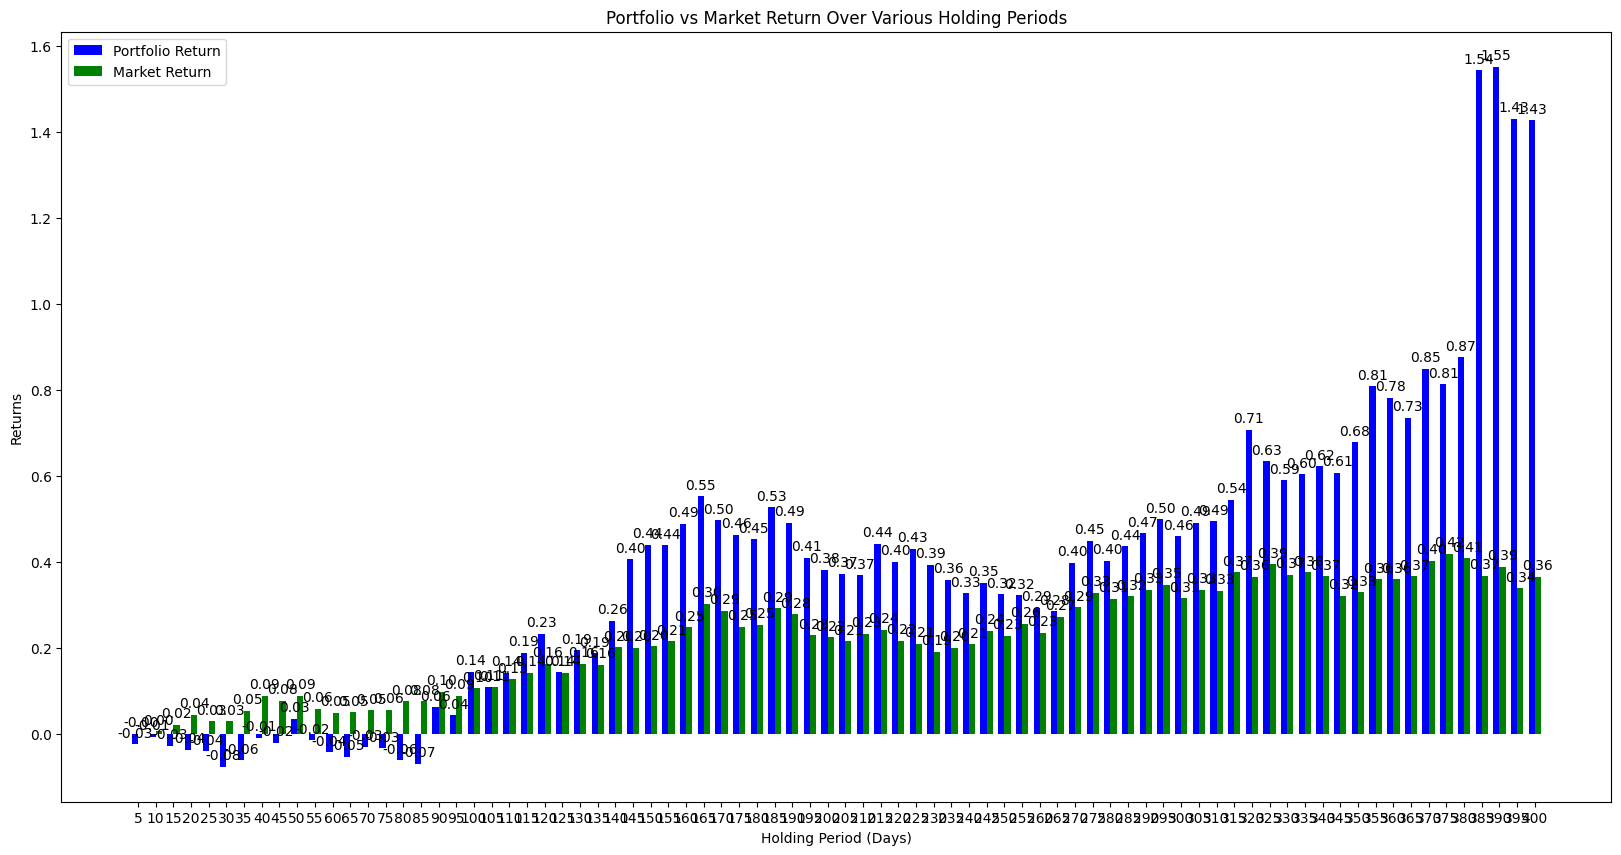

In [ ]:
# Set the width for each bar
bar_width = 0.35

# Set positions for the groups of bars
index = np.arange(len(comparison_df['Holding Period']))

plt.figure(figsize=(20,10))

# Create a bar plot for the portfolio returns
portfolio_bars = plt.bar(index - bar_width/2, comparison_df['Portfolio Return'], bar_width, label='Portfolio Return', color='blue')

# Create a bar plot for the market returns, positioned next to the first
market_bars = plt.bar(index + bar_width/2, comparison_df['Market Return'], bar_width, label='Market Return', color='green')

# Annotate each bar with its respective data value
for bar in portfolio_bars:
    yval = bar.get_height()
    plt.annotate(f'{yval:.2f}',
                 (bar.get_x() + bar.get_width() / 2, yval),
                 ha='center', va='bottom', textcoords="offset points", xytext=(0,3))

for bar in market_bars:
    yval = bar.get_height()
    plt.annotate(f'{yval:.2f}',
                 (bar.get_x() + bar.get_width() / 2, yval),
                 ha='center', va='bottom', textcoords="offset points", xytext=(0,3))

# Add labels, title, and legend
plt.xlabel('Holding Period (Days)')
plt.ylabel('Returns')
plt.title('Portfolio vs Market Return Over Various Holding Periods')
plt.xticks(index, comparison_df['Holding Period'])  # Set x-ticks to match the holding periods
plt.legend()

# Show the plot
plt.show()

# Risk-returns tradeoff

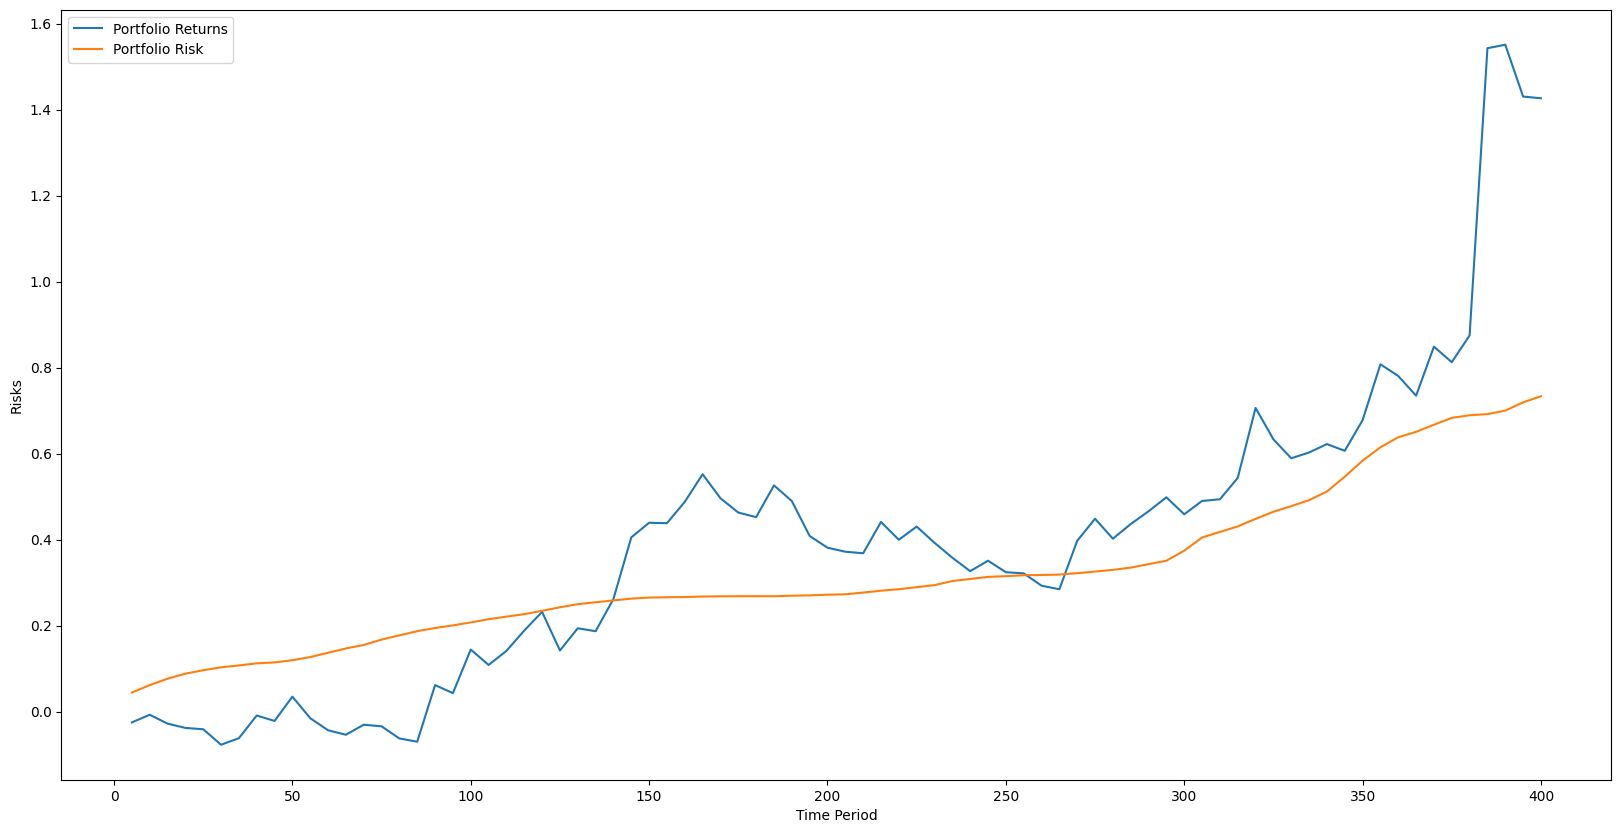

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(comparison_df['Holding Period'],comparison_df['Portfolio Return'],linewidth = 1.5)
plt.plot(comparison_df['Holding Period'],comparison_df['Portfolio Risk'],linewidth = 1.5)

legend = ['Portfolio Returns', 'Portfolio Risk']

plt.xlabel('Time Period')
plt.ylabel('Risks')
plt.legend(legend)

# Markowitz w/o transformer

[*********************100%***********************]  101 of 101 completed


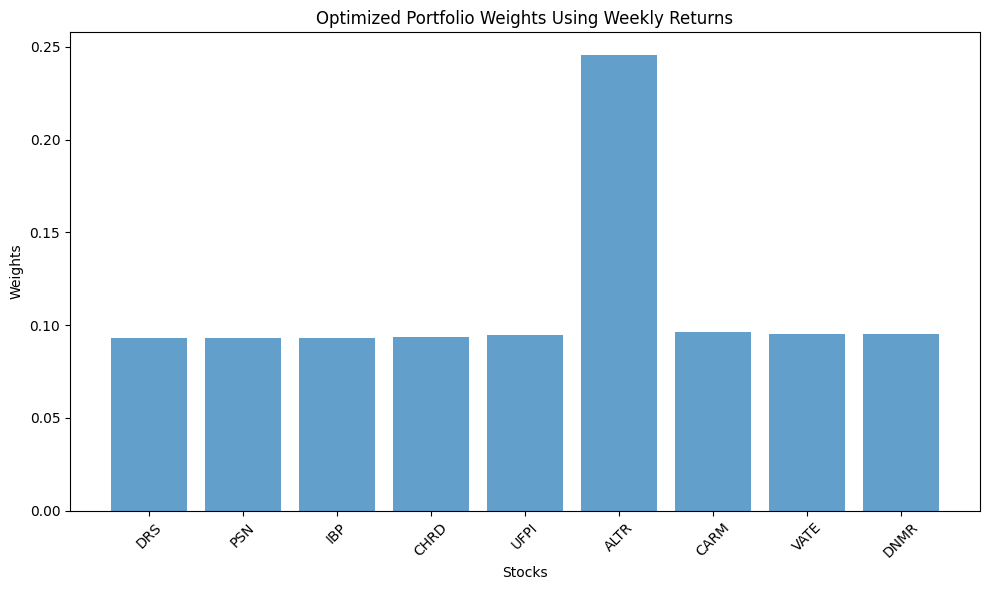

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Fetch historical stock data
try:
    data = yf.download(all_symbols, start=start_date, end=end_date)['Adj Close'].dropna(axis=1, how='all')
except Exception as e:
    print(f"Failed to download data: {e}")
    raise SystemExit("Exiting due to data download error.")


# Calculate weekly returns
weekly_data = data.resample('W').last()
weekly_returns = weekly_data.pct_change().dropna()

mean_daily_returns = weekly_returns.mean()



# Scale the returns
scaler = StandardScaler()
scaled_daily_returns = scaler.fit_transform(np.array(mean_daily_returns).reshape(-1,1))

top_indices_high = np.argsort(scaled_daily_returns[:50].flatten())[-int(high_cap_weight*10):] # Select top stocks
top_indices_low = np.argsort(-scaled_daily_returns[50:].flatten())[:int(low_cap_weight*10)] + 50
top_indices = []
top_indices.extend(top_indices_high)
top_indices.extend(top_indices_low)
top_stocks1 = [all_symbols[i] for i in top_indices]
top_mean_returns = scaled_daily_returns[top_indices]
cov_matrix = np.cov(top_mean_returns, rowvar=False)


#cov_matrix = np.cov(scaled_daily_returns, rowvar=False)

# Function for the Markowitz optimization
def markowitz_optimization(returns, cov_matrix, risk_aversion=4):
    n_assets = returns.shape[0]
    def objective(weights):
        return -(np.dot(weights, returns) - risk_aversion * np.dot(weights.T, np.dot(cov_matrix, weights)))
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    bounds = [(0, 1) for _ in range(n_assets)]
    result = minimize(objective, np.full(n_assets, 1/n_assets), method='SLSQP', bounds=bounds, constraints=constraints)
    if not result.success:
        print("Optimization failed: ", result.message)
        return None
    return result.x

# Run Markowitz optimization
optimized_result = markowitz_optimization(top_mean_returns, cov_matrix,risk_av)

# Visualize the optimized portfolio weights
plt.figure(figsize=(10, 6))
plt.bar(top_stocks1, optimized_result, alpha=0.7)
plt.title('Optimized Portfolio Weights Using Weekly Returns')
plt.xlabel('Stocks')
plt.ylabel('Weights')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df = pd.DataFrame({
    'Stock': top_stocks1,
    'Optimized Weight': optimized_result
})
spark_df = spark.createDataFrame(df)
spark.sql("CREATE DATABASE IF NOT EXISTS adhi_db")
if isinstance(risk_av, float):
    formatted_risk_av = str(risk_av).replace('.', '_')
else:
    formatted_risk_av = str(risk_av)

spark_df.write.format("parquet").mode("overwrite").saveAsTable(f"adhi_db.wotrans_weights_{formatted_risk_av}")

In [ ]:
# Symbols for your stocks and weights from Markowitz Optimization
weights = optimized_result

# Fetch historical data
data = yf.download(top_stocks1, start=start_date, end=end_date)['Adj Close']

# Function to calculate returns for holding periods
def calculate_returns_for_periods(data, periods):
    if isinstance(data, pd.Series):
        # Handle Series input for single stock/index data
        returns = pd.DataFrame(index=data.index)
        for period in periods:
            returns[f'{period} day return'] = (data.pct_change(periods=period)* weights).sum(axis=1)
    elif isinstance(data, pd.DataFrame):
        # Handle DataFrame input for multiple stocks
        returns = pd.DataFrame(index=data.index)
        for period in periods:
            returns[f'{period} day return'] = (data.pct_change(periods=period)* weights).sum(axis=1)
    return returns

# Calculate returns for various holding periods
#holding_periods = list(range(5,205,5))  # Example holding periods
portfolio_returns1 = calculate_returns_for_periods(data, holding_periods)

[*********************100%***********************]  9 of 9 completed


In [ ]:
# Extract the last value for each period to represent the period return
final_portfolio_returns1 = {period: portfolio_returns1[f'{period} day return'].iloc[-1] for period in holding_periods}
final_market_returns1 = {period: market_returns[f'{period} day return'].iloc[-1] for period in holding_periods}

In [ ]:
comparison_df1 = pd.DataFrame({
    'Holding Period': holding_periods,
    'Portfolio Return': list(final_portfolio_returns1.values()),
    'Market Return': list(final_market_returns1.values())
})

# Returns for traditional optimised portfolio

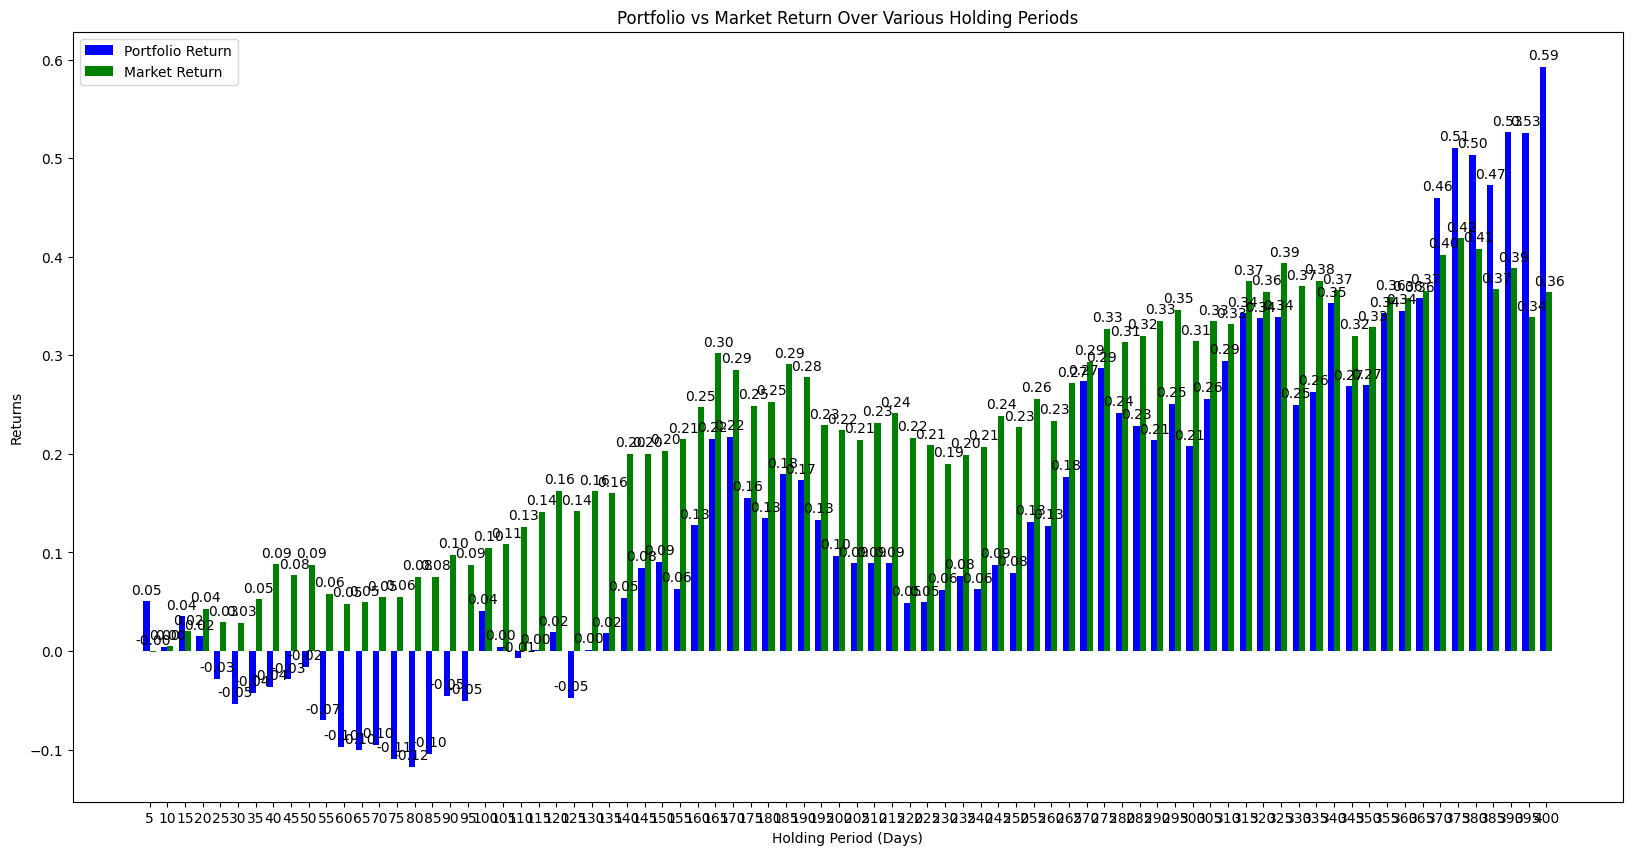

In [ ]:
# Set the width for each bar
bar_width = 0.35

plt.figure(figsize=(20,10))

# Set positions for the groups of bars
index = np.arange(len(comparison_df1['Holding Period']))

# Create a bar plot for the portfolio returns
portfolio_bars = plt.bar(index - bar_width/2, comparison_df1['Portfolio Return'], bar_width, label='Portfolio Return', color='blue')

# Create a bar plot for the market returns, positioned next to the first
market_bars = plt.bar(index + bar_width/2, comparison_df1['Market Return'], bar_width, label='Market Return', color='green')

# Annotate each bar with its respective data value
for bar in portfolio_bars:
    yval = bar.get_height()
    plt.annotate(f'{yval:.2f}',
                 (bar.get_x() + bar.get_width() / 2, yval),
                 ha='center', va='bottom', textcoords="offset points", xytext=(0,3))

for bar in market_bars:
    yval = bar.get_height()
    plt.annotate(f'{yval:.2f}',
                 (bar.get_x() + bar.get_width() / 2, yval),
                 ha='center', va='bottom', textcoords="offset points", xytext=(0,3))

# Add labels, title, and legend
plt.xlabel('Holding Period (Days)')
plt.ylabel('Returns')
plt.title('Portfolio vs Market Return Over Various Holding Periods')
plt.xticks(index, comparison_df1['Holding Period'])  # Set x-ticks to match the holding periods
plt.legend()

# Show the plot
plt.show()

# Returns curves

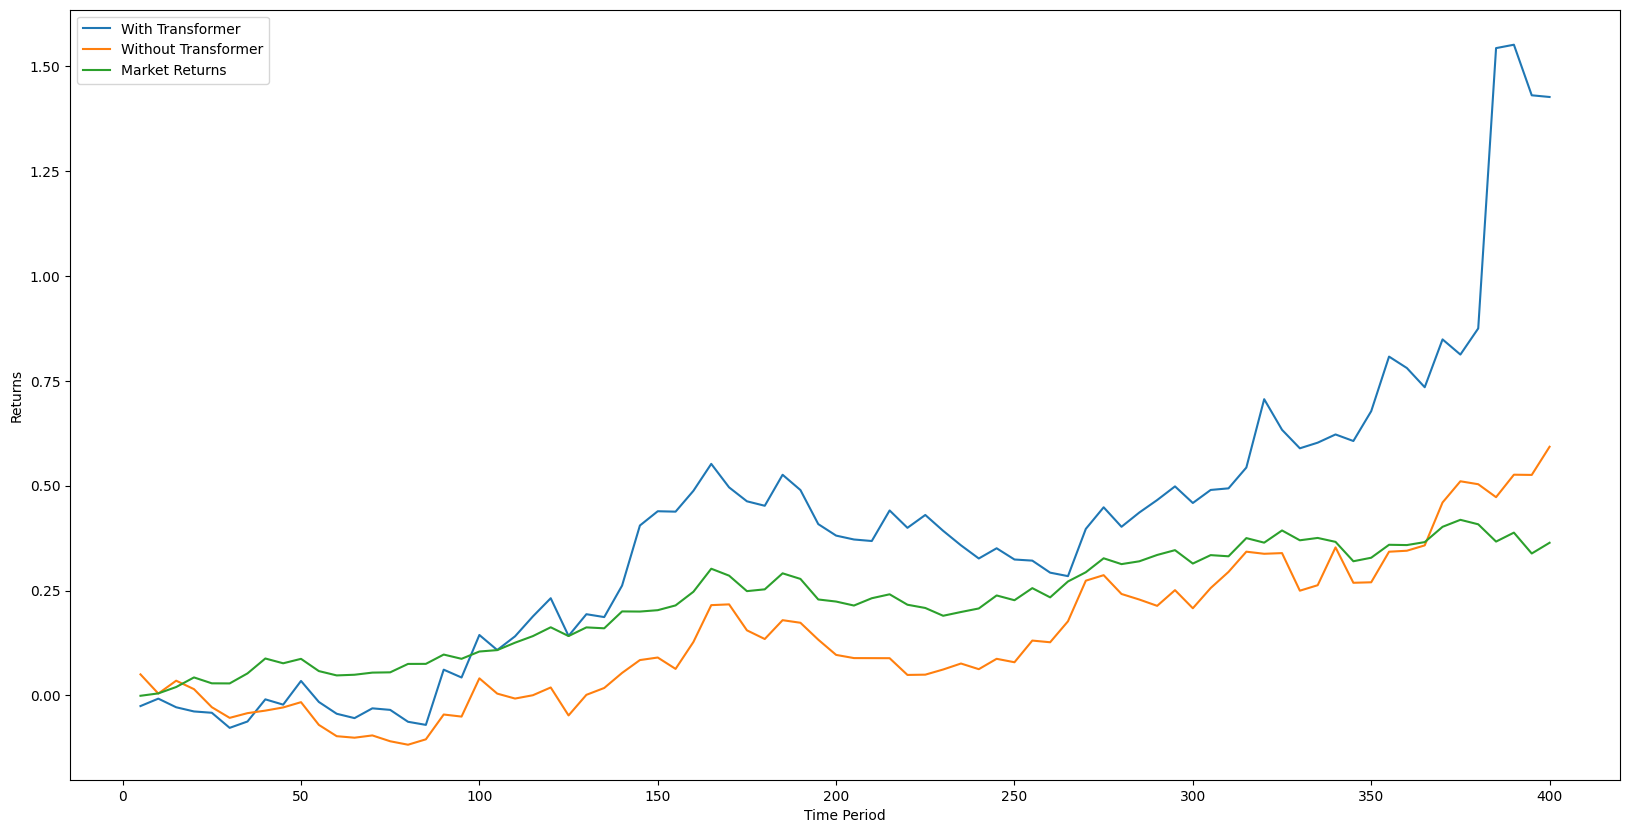

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(comparison_df['Holding Period'],comparison_df['Portfolio Return'],linewidth = 1.5)
plt.plot(comparison_df['Holding Period'],comparison_df1['Portfolio Return'],linewidth = 1.5)
plt.plot(comparison_df['Holding Period'],comparison_df['Market Return'],linewidth = 1.5)

legend = ['With Transformer','Without Transformer', 'Market Returns']

plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend(legend)

In [ ]:
df = pd.DataFrame({
    'With Transformer': comparison_df['Portfolio Return'],
    'Without Transformer': list(final_portfolio_returns1.values()),
    'Market Returns' : comparison_df['Market Return'],
    'Holding Periods' : comparison_df['Holding Period'],
    'Portfolio Risk' : comparison_df['Portfolio Risk'],
    'Market Risk' : comparison_df['Market Risk']
})

spark_df = spark.createDataFrame(df)
spark.sql("CREATE DATABASE IF NOT EXISTS adhi_db")
if isinstance(risk_av, float):
    formatted_risk_av = str(risk_av).replace('.', '_')
else:
    formatted_risk_av = str(risk_av)
spark_df.write.format("parquet").mode("overwrite").saveAsTable(f"adhi_db.stock_returns_{formatted_risk_av}")

# Model Performance

[*********************100%***********************]  101 of 101 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


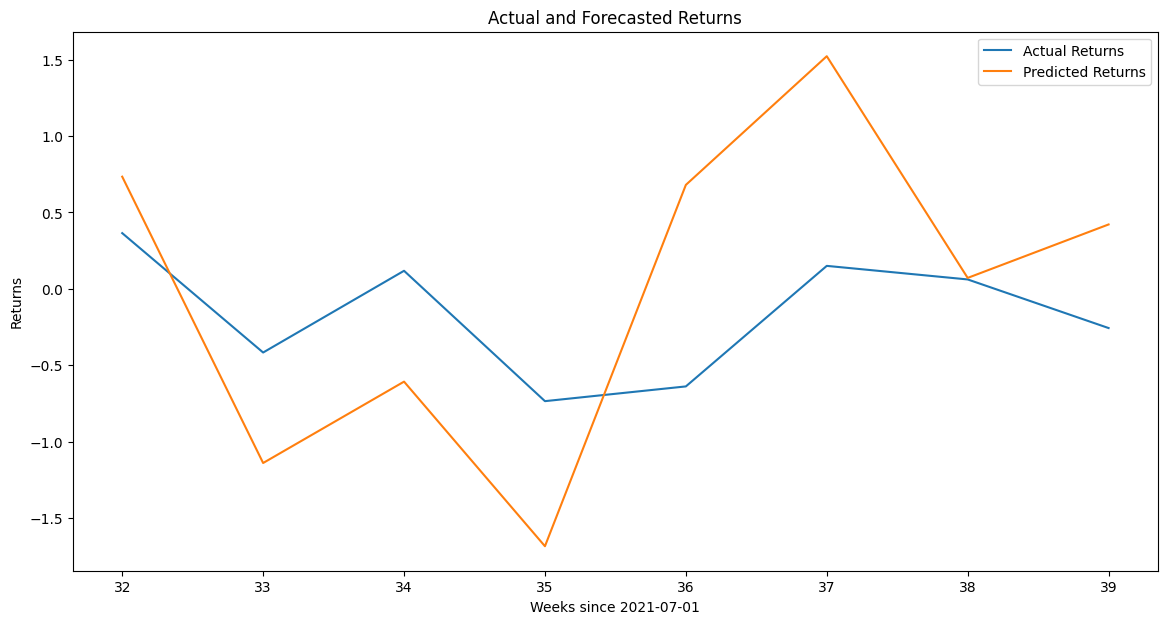

In [ ]:
from datetime import datetime, timedelta

forecasted_returns1 = np.mean(forecasted_returns,axis = 1)

date = datetime.strptime(end_date, '%Y-%m-%d')

# Calculate the date 8 weeks before
end_date1 = date + timedelta(weeks=forecast_horizon)

# Download and process data
try:
    data1 = yf.download(all_symbols, start=start_date, end=end_date1)['Adj Close'].dropna(axis=1, how='all')
except Exception as e:
    print(f"Failed to download data: {e}")
    raise SystemExit("Exiting due to data download error.")
weekly_data1 = data1.resample('W').last()
weekly_returns1 = weekly_data1.pct_change().dropna()

# Combine actual and predicted for plot
all_actual_returns = np.mean(weekly_returns1,axis=1)
scaler = StandardScaler()
predicted_returns = scaler.fit_transform(forecasted_returns1.reshape(-1,1))
all_actual_returns = scaler.fit_transform(np.array(all_actual_returns).reshape(-1,1))
predicted_index = range(len(all_actual_returns) - forecast_horizon, len(all_actual_returns))

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(predicted_index,all_actual_returns[predicted_index], label='Actual Returns')
plt.plot(predicted_index, predicted_returns, label='Predicted Returns')
#plt.plot(predicted_index, forecasted_returns, label='Predicted Returns')
plt.title('Actual and Forecasted Returns')
plt.xlabel('Weeks since ' + start_date)
plt.ylabel('Returns')
plt.legend()
plt.show()

## RMSE

In [ ]:
np.mean((all_actual_returns[predicted_index] - predicted_returns)**2)**0.5

0.8777246402749992